# __The Lottery Ticket Hypothesis__ _TensorFlow 2.0_ implementation:
The following code implements __The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks__ research paper by: _Jonathan Frankle, Michael Carbin_

Refer: _arXiv:1803.03635_


This code implements the hypothesis for _LeNet 300-100-10_ Dense Fully Connected neural network for MNIST multi-class classification

In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
tf.__version__

'2.0.0'

In [3]:
batch_size = 32
num_classes = 10
num_epochs = 50

In [4]:
# Data preprocessing and cleadning:
# input image dimensions
img_rows, img_cols = 28, 28

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [7]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [9]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 784), y_train = (60000, 10)
X_test.shape = (10000, 784), y_test = (10000, 10)


### Prepare MNIST dataset for _GradientTape_ training:

In [10]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [12]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [13]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

In [14]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [15]:
# The model is first trained without any pruning for 'num_epochs' epochs-
epochs = num_epochs

num_train_samples = X_train.shape[0]

end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

print("'end_step parameter' for this dataset =  {0}".format(end_step))

'end_step parameter' for this dataset =  93750


In [16]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
        end_step = 0, frequency=100
    )
}

In [17]:
l = tf.keras.layers

In [18]:
def pruned_nn(pruning_params):
    """
    Function to define the architecture of a neural network model
    following 300 100 architecture for MNIST dataset and using
    provided parameter which are used to prune the model.
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    pruned_model.add(l.InputLayer(input_shape=(784, )))
    pruned_model.add(Flatten())
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(units = 300, activation='relu', kernel_initializer=tf.initializers.GlorotUniform()),
        **pruning_params))
    # pruned_model.add(l.Dropout(0.2))
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(units = 100, activation='relu', kernel_initializer=tf.initializers.GlorotUniform()),
        **pruning_params))
    # pruned_model.add(l.Dropout(0.1))
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(units = num_classes, activation='softmax'),
        **pruning_params))
    
    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.001),
        metrics=['accuracy'])
    
    return pruned_model


In [19]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callbacks = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [20]:
# Instantiate a Neural Network-
orig_model = pruned_nn(pruning_params_unpruned)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [21]:
# Strip model of it's pruning parameters-
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [22]:
# Save random weights-
orig_model.save_weights("Random_Weights_Experimental.h5", overwrite=True)

In [23]:
# Save random weights-
orig_model.save_weights("Winning_Ticket_Weights_Experimental.h5", overwrite=True)

In [24]:
for layer in orig_model_stripped.trainable_weights:
    print(layer.shape)

(784, 300)
(300,)
(300, 100)
(100,)
(100, 10)
(10,)


In [25]:
orig_sum_params = 266610

In [26]:
# Count number of non-zero parameters in trained neural network-

print("\nIn original unpruned model, number of nonzero parameters in each layer are: \n")

orig_sum_params = 0

for layer in orig_model.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    orig_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(orig_sum_params))


In original unpruned model, number of nonzero parameters in each layer are: 

235200
0
30000
0
1000
0

Total number of trainable parameters = 266200



In [27]:
print("Difference = ", 266610 - 266200)

Difference =  410


### Create a mask:
A mask is created where all parameters equal to one.

This will be used later by _GradientTape_ for training the defined neural network.

In [28]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = pruned_nn(pruning_params_unpruned)

In [29]:
# Strip the model of its pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [30]:
# Assign all masks to one-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(
        tf.ones_like(
            input = wts,
            dtype = tf.float32
        )

    )
    # wts.assign(1.)
    # wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [31]:
print("\nMask model metrics:")
print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

masked_sum_params = 0

for layer in mask_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))


Mask model metrics:
layer-wise manner model, number of nonzero parameters in each layer are: 

235200
300
30000
100
1000
10

Total number of trainable parameters = 266610



### Input values for pruning given neural network:

In [32]:
def compute_weights_pruned_each_round(orig_params, p, n):
    '''
    Function to compute % of weights pruned in each round

    Input:
    orig_params:    number of parameters in model BEFORE any pruning
    p:              final sparsity desired AFTER 'n' rounds of iterative pruning
    n:              number of icterative pruning rounds


    Returns:
    numpy array holding % of weights pruned in each round
    '''

    if p > 1:
        p = p / 100

    # numpy array to hold % of weights pruned in each of 'n' round-
    # wts_pruned = np.zeros(shape = n)
    wts_pruned = np.zeros(shape = n + 1)

    params = orig_params

    for i in range(n):
        wts_remain = params * (1 - p) ** (1/n)	# % of weights surviving each round
        params = wts_remain
        wts_pruned[i] = (orig_params - params) / orig_params

        # print("\nwts remaining = {0:.2f} after round = {1}".format(wts_remain, i))
        # print("wts pruned = {0:.2f} in round = {1}".format(((orig_params - params)/orig_params * 100), i))


    return wts_pruned


### __Iterative Pruning parameters:__

In [33]:
# Desired final sparsity in neural network-
p = 0.789

# Number of iterative pruning rounds-
num_pruning_rounds = 5

In [34]:
wts_np = compute_weights_pruned_each_round(
    orig_params=266610,
    p = p, n = num_pruning_rounds)


In [35]:
# You prune more than 78.9% to show validity of hypothesis-
wts_np[5] = 0.8

In [36]:
print("\n% of weights to be pruned in each round:\n")
for i in range(wts_np.shape[0]):
    print("Round {0} prunes = {1:.4f}%".format(i + 1, wts_np[i] * 100))


% of weights to be pruned in each round:

Round 1 prunes = 26.7418%
Round 2 prunes = 46.3323%
Round 3 prunes = 60.6840%
Round 4 prunes = 71.1978%
Round 5 prunes = 78.9000%
Round 6 prunes = 80.0000%


### Python 3 dictionary to hold model training metrics for each of _n_ rounds:

In [37]:
# Method - 1: Nested Python 3 dictionaries:
history_main = {}

for x in range(num_pruning_rounds + 1):
    history = {}
    history['accuracy'] = np.zeros(shape = num_epochs)
    history['val_accuracy'] = np.zeros(shape = num_epochs)
    history['loss'] = np.zeros(shape = num_epochs)
    history['val_loss'] = np.zeros(shape = num_epochs)

    history_main[x + 1] = history


In [38]:
# Sanity check-
history_main[2]['val_loss']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [40]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [41]:
best_val_loss = 1
loc_patience = 0

In [42]:
for i in range(1, num_pruning_rounds + 1):
    
    print("\n\n\nIterative pruning round: {0}\n\n".format(i))
    
    # Define 'train_one_step()' and 'test_step()' functions here-
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None


    # Instantiate a model
    model_gt = pruned_nn(pruning_params_unpruned)
    
    # Load winning ticket (from above-)
    model_gt.load_weights("Winning_Ticket_Weights_Experimental.h5")
    
    # Strip model of pruning parameters-
    model_gt_stripped = sparsity.strip_pruning(model_gt)
    
    
    # Train model using 'GradientTape'-
    
    # Initialize parameters for Early Stopping manual implementation-
    best_val_loss = 1
    loc_patience = 0
    
    for epoch in range(num_epochs):
    
        if loc_patience >= patience:
            print("\n'EarlyStopping' called!\n")
            break
        
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
        
        '''
        # Initialize 'grad_mask_mul' list-
        grad_mask_mul = []
    
        # Initialize all values to one-
        for wts in mask_model_stripped.trainable_weights:
            grad_mask_mul.append(wts.assign(tf.ones_like(input = wts,dtype = tf.float32)))
    
        # Convert from Python list to tf.Tensor-
        grad_mask_mul = tf.convert_to_tensor(grad_mask_mul, dtype=tf.float32)
    
        print("type(grad_mask_mul): {0}".format(type(grad_mask_mul)))
        '''
    
        for x, y in train_dataset:
            # train_one_step(model_gt_stripped, mask_model, optimizer, x, y, grad_mask_mul)
            train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(x_t, y_t)
            test_step(model_gt_stripped, optimizer, x_t, y_t)

        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
        history_main[i]['accuracy'][epoch] = train_accuracy.result() * 100
        history_main[i]['loss'][epoch] = train_loss.result()
        history_main[i]['val_loss'][epoch] = test_loss.result()
        history_main[i]['val_accuracy'][epoch] = test_accuracy.result() * 100
        '''
        history['accuracy'][epoch] = train_accuracy.result() * 100
        history['loss'][epoch] = train_loss.result()
        history['val_loss'][epoch] = test_loss.result()
        history['val_accuracy'][epoch] = test_accuracy.result() * 100     
        '''
        
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in model_gt_stripped.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
        # Code for manual Early Stopping:
        if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_val_loss = test_loss.result()
        
            # reset 'loc_patience' variable-
            loc_patience = 0
        
        else:  # there is no improvement in monitored metric 'val_loss'
            loc_patience += 1  # number of epochs without any improvement

    
    # Resize numpy arrays according to the epoch when 'EarlyStopping' was called-
    for metrics in history.keys():
        history_main[i][metrics] = np.resize(history_main[i][metrics], new_shape = epoch)
        # history[metrics] = np.resize(history[metrics], new_shape=epoch)
     
    
    # Save trained model weights-
    model_gt.save_weights("Trained_Weights_Experimental.h5", overwrite=True)
    
    
    
    
    # Prune trained model:
    
    print("\n% of weights to be pruned in round = {0} is: {1:.4f}\n".format(i, wts_np[i - 1]))
    
    # Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
    pruning_params_constantsparsity = {
        'pruning_schedule': sparsity.ConstantSparsity(
            target_sparsity=wts_np[i - 1], begin_step=100,
            end_step = end_step, frequency=100
        )
    }
    
    # Instantiate a Nueal Network model to be pruned using parameters from above-
    pruned_model = pruned_nn(pruning_params_constantsparsity)
    
    # Load weights from original trained and unpruned model-
    pruned_model.load_weights("Trained_Weights_Experimental.h5")
    
    # Train pruned NN-
    history_pruned = pruned_model.fit(
        x = X_train, y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        verbose = 1,
        callbacks = callbacks,
        validation_data = (X_test, y_test),
        shuffle = True
    )
    
    # Strip the pruning wrappers from pruned model-
    pruned_model_stripped = sparsity.strip_pruning(pruned_model)
    
    # print("\nIn pruned model, number of nonzero parameters in each layer are: \n")
    pruned_sum_params = 0
    
    for layer in pruned_model_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("\nRound = {0}, total number of trainable parameters = {1}\n".format(i, pruned_sum_params))
    # print("\nTotal number of trainable parameters = {0}\n".format(pruned_sum_params))
    
    # Sanity-check: confirm that p = 30% of the weights are actually pruned away from the network-
    print("\nRound = {0}, % of weights pruned away = {1:.2f}%\n".format( \
                                                i, (orig_sum_params - pruned_sum_params) / orig_sum_params * 100))
    
    # Save weights of PRUNED and Trained model BEFORE stripping-
    pruned_model.save_weights("Pruned_Weights_Experimental.h5", overwrite = True)
    
    
    # Create a mask:
    
    # Instantiate a new neural network model for which, the mask is to be created,
    mask_model = pruned_nn(pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    mask_model.load_weights("Pruned_Weights_Experimental.h5")
    
    # Strip the model of its pruning parameters-
    mask_model_stripped = sparsity.strip_pruning(mask_model)
    
    # For each layer, for each weight which is 0, leave it, as is.
    # And for weights which survive the pruning,reinitialize it to ONE (1)-
    for wts in mask_model_stripped.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))
    
    
    
    
    # Extract Winning Ticket:
    
    # Instantiate a new neural network model for which, the weights are to be extracted-
    winning_ticket_model = pruned_nn(pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    winning_ticket_model.load_weights("Pruned_Weights_Experimental.h5")
    
    # Strip the model of its pruning parameters-
    winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)
    
    # For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
    # reinitialize it to the value, the model received BEFORE it was trained and pruned-
    for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights,
                                    winning_ticket_model_stripped.trainable_weights):
        pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))
    
    
    # Save the weights (with pruning parameters) extracted to a file-
    winning_ticket_model.save_weights("Winning_Ticket_Weights_Experimental.h5", overwrite=True)
    
    
    
    




Iterative pruning round: 1


Epoch 1, Loss: 0.2008, Accuracy: 98.8314, Test Loss: 0.1255, Test Accuracy: 99.215981
Total number of trainable parameters = 266610

Epoch 2, Loss: 0.0831, Accuracy: 99.5003, Test Loss: 0.0867, Test Accuracy: 99.503967
Total number of trainable parameters = 266610

Epoch 3, Loss: 0.0598, Accuracy: 99.6267, Test Loss: 0.0839, Test Accuracy: 99.488937
Total number of trainable parameters = 266610

Epoch 4, Loss: 0.0440, Accuracy: 99.7223, Test Loss: 0.0732, Test Accuracy: 99.569954
Total number of trainable parameters = 266610

Epoch 5, Loss: 0.0335, Accuracy: 99.7789, Test Loss: 0.0845, Test Accuracy: 99.549934
Total number of trainable parameters = 266610

Epoch 6, Loss: 0.0282, Accuracy: 99.8145, Test Loss: 0.1000, Test Accuracy: 99.506897
Total number of trainable parameters = 266610

Epoch 7, Loss: 0.0248, Accuracy: 99.8464, Test Loss: 0.0793, Test Accuracy: 99.591949
Total number of trainable parameters = 266610


'EarlyStopping' called!


% of weigh

### Next Steps:
The paper states that the maximum pruning that can be achieved before the neural network performance drops is 78.9%. This means that if the sparsity/pruning is greater than 78.9%, then the trained neural network model's performance (in terms of Early Stopping and Testing dataset accuracy and loss) should go down.

The next lines of code, attempts to validate this:

In [63]:
# Instantiate NN-
winning_ticket_model = pruned_nn(pruning_params_unpruned)

In [64]:
# Load winning ticket from above-
winning_ticket_model.load_weights("Winning_Ticket_Weights_Experimental.h5")

In [65]:
# Strip model of pruning parameters-
winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)

In [66]:
# Count number of non-zero parameters in winning ticket (sanity check)-

print("\nWinning Ticket model, number of nonzero parameter in each layer are:\n")

winning_tkt_sum_params = 0

for layer in winning_ticket_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    winning_tkt_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(winning_tkt_sum_params))


Winning Ticket model, number of nonzero parameter in each layer are:

49627
0
6330
0
211
0

Total number of trainable parameters = 56168



In [67]:
print("\nWinning ticket after {0} rounds has {1:.4f}% of weights pruned off\n".format(
    num_pruning_rounds, ((orig_sum_params - winning_tkt_sum_params) / orig_sum_params * 100)
))


Winning ticket after 5 rounds has 78.9001% of weights pruned off



In [68]:
# Instantiate a mask model-
mask_model = pruned_nn(pruning_params_unpruned)

In [69]:
# Load winning ticket weights-
mask_model.load_weights("Winning_Ticket_Weights_Experimental.h5")

In [70]:
# Strip pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [71]:
# For each layer, for each weight which is 0, leave it, as is.
# And for weights which survive the pruning,reinitialize it to ONE (1)-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [72]:
# Count number of non-zero parameters in winning ticket (sanity check)-

print("\nMask model, number of nonzero parameter in each layer are:\n")

mask_model_sum_params = 0

for layer in mask_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    mask_model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(mask_model_sum_params))


Mask model, number of nonzero parameter in each layer are:

49627
0
6330
0
211
0

Total number of trainable parameters = 56168



In [77]:
assert(winning_tkt_sum_params == mask_model_sum_params), "number of parameters in winning ticket model and mask model should match"

In [78]:
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    def train_step(data, labels):
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
        
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    return None

In [79]:
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    return None


In [80]:
# Define variables for manual Early Stopping-
best_val_loss = 1
loc_patience = 0

In [81]:
for epoch in range(num_epochs):
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
        
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
        
    for x, y in train_dataset:
        # train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)
        train_one_step(winning_ticket_model_stripped, mask_model_stripped, optimizer, x, y)

    for x_t, y_t in test_dataset:
        # test_step(model_gt_stripped, optimizer, x_t, y_t)
        test_step(winning_ticket_model_stripped, optimizer, x_t, y_t)
    
    history_main[num_pruning_rounds + 1]['accuracy'][epoch] = train_accuracy.result() * 100
    history_main[num_pruning_rounds + 1]['loss'][epoch] = train_loss.result()
    history_main[num_pruning_rounds + 1]['val_loss'][epoch] = test_loss.result()
    history_main[num_pruning_rounds + 1]['val_accuracy'][epoch] = test_accuracy.result() * 100

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
    print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
    # Count number of non-zero parameters in each layer and in total-
    # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

    model_sum_params = 0
    
    for layer in winning_ticket_model_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
    # Code for manual Early Stopping:
    if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = test_loss.result()
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    


Epoch 1, Loss: 0.1061, Accuracy: 99.3802, Test Loss: 0.0676, Test Accuracy: 99.573967
Total number of trainable parameters = 56168

Epoch 2, Loss: 0.0335, Accuracy: 99.7997, Test Loss: 0.0598, Test Accuracy: 99.618950
Total number of trainable parameters = 56168

Epoch 3, Loss: 0.0184, Accuracy: 99.8988, Test Loss: 0.0600, Test Accuracy: 99.628952
Total number of trainable parameters = 56168

Epoch 4, Loss: 0.0113, Accuracy: 99.9428, Test Loss: 0.0647, Test Accuracy: 99.650955
Total number of trainable parameters = 56168

Epoch 5, Loss: 0.0079, Accuracy: 99.9589, Test Loss: 0.0676, Test Accuracy: 99.640938
Total number of trainable parameters = 56168


'EarlyStopping' called!



In [82]:
# Save trained model-
winning_ticket_model.save_weights("Winning_Ticket_Weights_Pruned_more_80_Experimental.h5", overwrite=True)

In [85]:
# Specify the parameters to be used for layer-wise pruning-
pruning_params_constantsparsity = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=wts_np[num_pruning_rounds], begin_step=100,
        end_step = end_step, frequency=100
    )
}

In [86]:
# Instantiate a Neural Network model to be pruned-
pruned_model = pruned_nn(pruning_params_constantsparsity)

In [87]:
# Load weights of winning ticket from previous round to be PRUNED-
pruned_model.load_weights("Winning_Ticket_Weights_Pruned_more_80_Experimental.h5")

In [88]:
print("Pruning parameters of (GradientTape) trained model\n")

# Train pruned Neural Network-
history_pruned_gt = pruned_model.fit(
    x = X_train, y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (X_test, y_test),
    shuffle = True
)

Pruning parameters of (GradientTape) trained model

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 172us/sample - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0792 - val_accuracy: 0.9808
Epoch 2/50
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.0775 - val_accuracy: 0.9818
Epoch 3/50
60000/60000 [==============================] - 10s 161us/sample - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0958 - val_accuracy: 0.9807
Epoch 4/50
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0819 - val_accuracy: 0.9823
Epoch 5/50
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0939 - val_accuracy: 0.9821


In [89]:
# Strip pruning wrapper off-
pruned_model_stripped = sparsity.strip_pruning(pruned_model)

In [90]:
# Count number of non-zero parameters [Round - 2]-
pruned_sum_params = 0
    
for layer in pruned_model_stripped.trainable_weights:
    pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nPruned model, # of non-zero trainable parameters = {0}".format(pruned_sum_params))


Pruned model, # of non-zero trainable parameters = 53645


In [91]:
print("\n% of weights pruned in {0} round = {1:.4f}%\n".format(
    num_pruning_rounds + 1, ((orig_sum_params - pruned_sum_params) / orig_sum_params * 100)
))


% of weights pruned in 6 round = 79.8479%



In [92]:
# Save weights-
pruned_model.save_weights("Pruned_Weights_Pruned_more_80_Experimental.h5")

In [93]:
# Instantiate a new neural network model for which, the weights are to be extracted, according to the paper-
winning_ticket_model = pruned_nn(pruning_params_unpruned)

In [94]:
# Load weights of PRUNED model-
winning_ticket_model.load_weights("Pruned_Weights_Pruned_more_80_Experimental.h5")

In [95]:
# Strip the model of its pruning parameters-
winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)

In [97]:
# For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
# reinitialize it to the value, the model received BEFORE it was trained and pruned-
for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights, winning_ticket_model_stripped.trainable_weights):
    pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))

In [98]:
# Save the weights (with pruning parameters) extracted to a file-
winning_ticket_model.save_weights("Winning_Ticket_Weights_more_80_Experimental.h5", overwrite=True)

In [128]:
# Instantiate NN-
winning_ticket_model = pruned_nn(pruning_params_unpruned)

In [129]:
# Load winning ticket from above-
winning_ticket_model.load_weights("Winning_Ticket_Weights_more_80_Experimental.h5")

In [130]:
# Strip model of pruning parameters-
winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)

In [131]:
# Count number of non-zero parameters in winning ticket (sanity check)-

print("\nWinning Ticket model, number of nonzero parameter in each layer are:\n")

winning_tkt_sum_params = 0

for layer in winning_ticket_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    winning_tkt_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(winning_tkt_sum_params))


Winning Ticket model, number of nonzero parameter in each layer are:

47040
0
6000
0
200
0

Total number of trainable parameters = 53240



In [133]:
print("\nWinning ticket after {0} rounds has {1:.4f}% of weights pruned off\n".format(
    num_pruning_rounds, ((orig_sum_params - winning_tkt_sum_params) / orig_sum_params * 100)
))


Winning ticket after 5 rounds has 80.0000% of weights pruned off



In [134]:
# Instantiate a mask model-
mask_model = pruned_nn(pruning_params_unpruned)

In [135]:
# Load winning ticket weights-
mask_model.load_weights("Winning_Ticket_Weights_more_80_Experimental.h5")

In [136]:
# Strip pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [137]:
# For each layer, for each weight which is 0, leave it, as is.
# And for weights which survive the pruning,reinitialize it to ONE (1)-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [138]:
# Count number of non-zero parameters in winning ticket (sanity check)-

print("\nMask model, number of nonzero parameter in each layer are:\n")

mask_model_sum_params = 0

for layer in mask_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    mask_model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(mask_model_sum_params))


Mask model, number of nonzero parameter in each layer are:

47040
0
6000
0
200
0

Total number of trainable parameters = 53240



In [139]:
assert(winning_tkt_sum_params == mask_model_sum_params), "number of parameters in winning ticket model and mask model should match"

In [140]:
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    def train_step(data, labels):
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
        
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    return None

In [141]:
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    return None


In [142]:
# Define variables for manual Early Stopping-
best_val_loss = 1
loc_patience = 0

In [143]:
for epoch in range(num_epochs):
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
        
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
        
    for x, y in train_dataset:
        # train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)
        train_one_step(winning_ticket_model_stripped, mask_model_stripped, optimizer, x, y)

    for x_t, y_t in test_dataset:
        # test_step(model_gt_stripped, optimizer, x_t, y_t)
        test_step(winning_ticket_model_stripped, optimizer, x_t, y_t)
    
    history_main[num_pruning_rounds + 1]['accuracy'][epoch] = train_accuracy.result() * 100
    history_main[num_pruning_rounds + 1]['loss'][epoch] = train_loss.result()
    history_main[num_pruning_rounds + 1]['val_loss'][epoch] = test_loss.result()
    history_main[num_pruning_rounds + 1]['val_accuracy'][epoch] = test_accuracy.result() * 100

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
    print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
    # Count number of non-zero parameters in each layer and in total-
    # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

    model_sum_params = 0
    
    for layer in winning_ticket_model_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
    # Code for manual Early Stopping:
    if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = test_loss.result()
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    


Epoch 1, Loss: 0.1035, Accuracy: 99.3867, Test Loss: 0.0654, Test Accuracy: 99.600967
Total number of trainable parameters = 53240

Epoch 2, Loss: 0.0319, Accuracy: 99.8091, Test Loss: 0.0574, Test Accuracy: 99.646935
Total number of trainable parameters = 53240

Epoch 3, Loss: 0.0173, Accuracy: 99.9105, Test Loss: 0.0650, Test Accuracy: 99.621964
Total number of trainable parameters = 53240

Epoch 4, Loss: 0.0107, Accuracy: 99.9456, Test Loss: 0.0663, Test Accuracy: 99.619942
Total number of trainable parameters = 53240

Epoch 5, Loss: 0.0069, Accuracy: 99.9659, Test Loss: 0.0699, Test Accuracy: 99.626938
Total number of trainable parameters = 53240


'EarlyStopping' called!



In [144]:
epoch

5

In [145]:
# Resize numpy arrays according to the epoch when 'EarlyStopping' was called-
for metrics in history_main[num_pruning_rounds + 1].keys():
# for metrics in history.keys():
    history_main[num_pruning_rounds + 1][metrics ] = np.resize(history_main[num_pruning_rounds + 1][metrics], new_shape = epoch)
    # history[metrics] = np.resize(history[metrics], new_shape=epoch)


In [82]:
# Save trained model-
winning_ticket_model.save_weights("Winning_Ticket_Weights_Pruned_more_80_Experimental.h5", overwrite=True)

## Visualize: Training Process [Scalar Metrics]

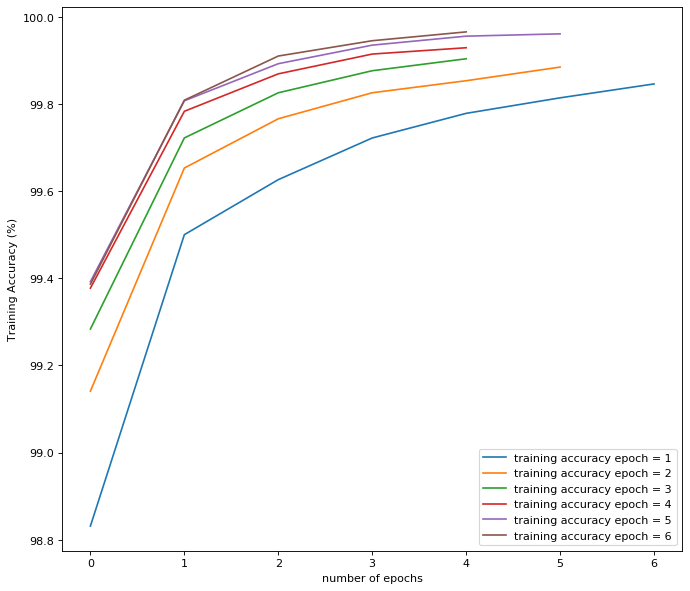

In [147]:
# Plot the different epoch's training accuracy:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for epoch in history_main.keys():
    plt.plot(history_main[epoch]['accuracy'], label = "training accuracy epoch = {0}".format(epoch))

plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("Training Accuracy (%)")
plt.show()

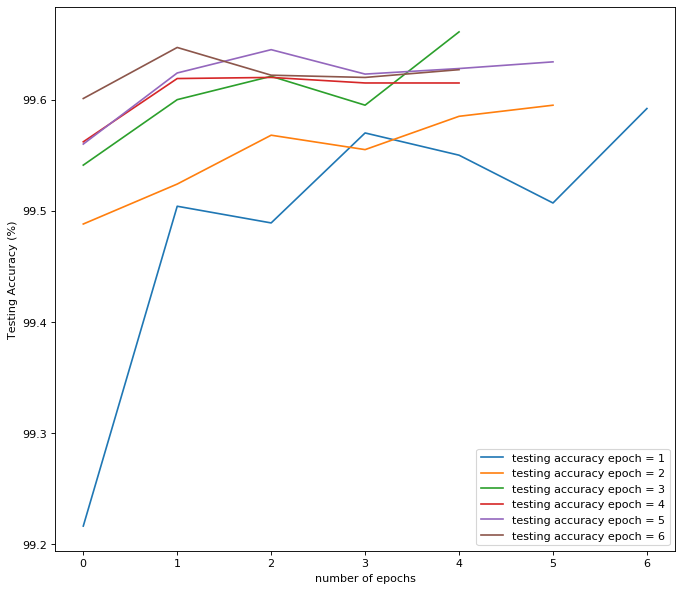

In [148]:
# Plot the different epoch's testing accuracy:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for epoch in history_main.keys():
    plt.plot(history_main[epoch]['val_accuracy'], label = "testing accuracy epoch = {0}".format(epoch))

plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("Testing Accuracy (%)")
plt.show()

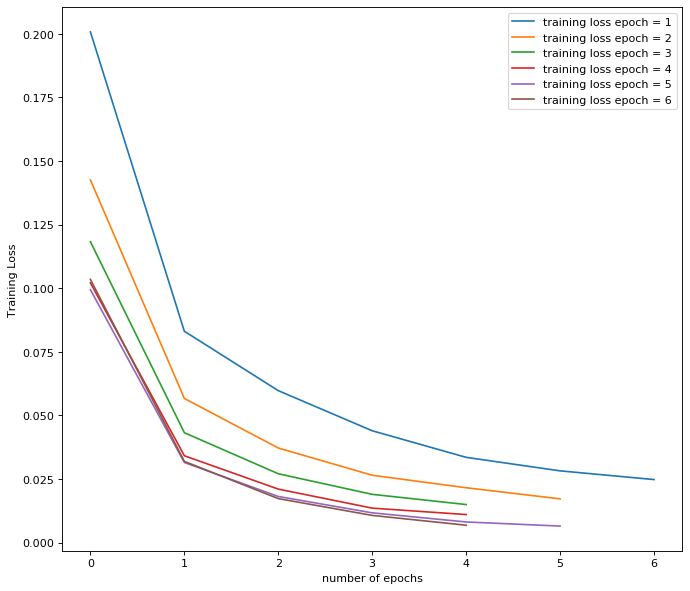

In [149]:
# Plot the different epoch's training loss:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for epoch in history_main.keys():
    plt.plot(history_main[epoch]['loss'], label = "training loss epoch = {0}".format(epoch))

plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("Training Loss")
plt.show()

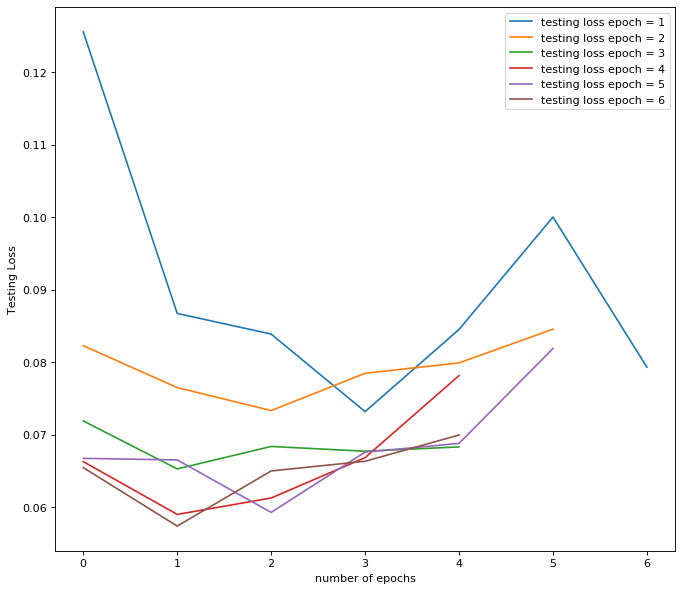

In [150]:
# Plot the different epoch's testing loss:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for epoch in history_main.keys():
    plt.plot(history_main[epoch]['val_loss'], label = "testing loss epoch = {0}".format(epoch))

plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("Testing Loss")
plt.show()